In [11]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
import scipy as sp
from matplotlib import pyplot as plt
import time
from itertools import product
from random import sample
from sklearn.preprocessing import normalize
from scipy.linalg import norm
from scipy.spatial import distance
from google.colab import drive

In [12]:
drive.mount('/content/drive')
rootfolder = '/content/drive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Useful function for plot the dictionary

In [13]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Set all the paramters for the anomaly detection

In [14]:
# patch size (the patch is square)
p = 15
M = p**2

# number of patches in the training set for dictionary learning
npatch_S = 10000

# number of patches to estimate the confidence region
npatch_V = 1000

# number of patches to estimate the threshold
npatch_T = 1000

# paramters for the dictionary learning using the KSVD
niter_dl = 10
natom = int(np.round(p**2*1.5))
L = 4

# regularization parameters for the l1 sparse coding
lmbda = 0.18

Construct the training and validation sets
------------------------------------------

In [15]:
# load the training image and rescale it in [0,1]
img = imread(f'{rootfolder}/data/img_normal.png') / 255
imsz = img.shape

# extract random patches from the image and store them in a matrices S, V
S = np.zeros((M, npatch_S))
V = np.zeros((M, npatch_V))

random_coord_patches = sample(list(product(range(imsz[0] - p + 1), repeat=2)), k=npatch_S)
# tuple with coordinates for rows and columns
count = 0
for x,y in random_coord_patches:
  S[:,count] = img[x:x+p,y:y+p].flatten()
  count += 1

random_coord_patches = sample(list(product(range(imsz[0] - p + 1), repeat=2)), k=npatch_V)
# tuple with coordinates for rows and columns
count = 0
for x,y in random_coord_patches:
  V[:,count] = img[x:x+p,y:y+p].flatten()
  count += 1

Dictionary Learning
-------------------
Perform preprocessing on the patches in $S$

In [16]:
# PREPROCESSING: exclude black patches from S
v = np.median(S, axis=0)
S = S[:,v > 0.06]

In [17]:
# PREPROCESSING: remove the mean from each patch
for i in range(S.shape[1]):
  S[:,i] = S[:,i] - np.mean(S[:,i])

Perform dictionary learning or load a pretrained dictionary

In [18]:
### OMP FUNCTION
def OMP(s, D, L, tau):
  M, N = D.shape
  x = np.zeros(N)
  r = s # residual
  omega = [] # support set

  while np.count_nonzero(x) < L and np.linalg.norm(r, ord=2) > tau:

      # SWEEP STEP: look for the column of D that matches at best noisySignal
      # compute the residual w.r.t. each column of D
      e = np.zeros(N)
      for j in range(N):
          dj = D[:,j].copy()
          e[j] = (np.linalg.norm(r, ord=2)**2) - (np.dot(np.transpose(r), dj)**2) / (np.linalg.norm(dj, ord=2)**2)

      # find the column of D that matches at best r
      jStar = np.argmin(e)

      # UPDATE the support set with the jStar coefficient
      omega.append(jStar)

      # update the coefficients by solving the least square problem min ||D_omega x - s ||
      x = np.zeros(N)
      x[omega] = np.linalg.solve(np.dot(np.transpose(D[:,omega]),D[:,omega]), np.dot(np.transpose(D[:,omega]), s))

      # update the residual
      r = s - np.dot(D,x)

  return x

In [19]:
### IRLS FUNCTION
def IRLS(s, D, lmbda, x0=None):
    if x0 is None:
        x0 = np.zeros(D.shape[1])
    delta = 1e-6
    max_iter = niter_dl
    distanceX = 1e10
    toll_x = 1e-3

    x = x0

    cnt = 0
    while cnt < max_iter or distanceX > toll_x:
        W = np.diag(1 / (np.abs(x) + delta))
        # solve the weighted regularized LS system
        x_new = np.linalg.solve((2 * lmbda * W + D.T @ D), D.T @ s)
        distanceX = np.linalg.norm(x - x_new, ord=2)
        x = x_new
        cnt = cnt + 1
    return x_new

In [20]:
### KSVD FUNCTION
def KSVD(S):

  # number of columns of the dictionary
  N = natom
  M = S.shape[0]
  npatch = S.shape[1]

  # intialize the dictionary
  D = np.random.random((M, N))
  # normalize each column of D (zero mean and unit norm)
  for i in range(N):
    D[:,i] = D[:,i] - D[:,i].mean()
  D = normalize(D, axis=0, norm='l2')

  # number of iteration of the KSVD
  max_iter = niter_dl

  # initialize the coefficient matrix
  X = np.zeros((N, npatch))

  for iter in range(max_iter):
      # perform the sparse coding via OMP of all the columns of S
      for n in range(npatch):
          X[:, n] = OMP(S[:,n], D, L, 0)

      # iterate over the columns of D
      for j in range(N):
          # find which signals uses the j-th atom in the sparse coding
          omega = np.nonzero(X[j,:])[0]

          if len(omega) == 0:
              # if the atom is never used then ignore or substitute it with a random vector
              D[:,j] = np.random.random(M)
              # normalize each column of D (zero mean and unit norm)
              D[:,j] = D[:,j] - D[:,j].mean()
              D = normalize(D, axis=0, norm='l2')
          else:
              # compute the residual matrix E, ignoring the j-th atom
              E = S
              for col in range(N):
                if col != j:
                  E = E - np.dot(D[:,col].reshape((M,1)),X[col,:].reshape((1,npatch)))

              # restrict E to the columns indicated by omega
              Eomega = E[:,omega]

              # compute the SVD of Eomega
              U, Sigma, V = np.linalg.svd(Eomega, full_matrices=False)

              # update the dictionary
              D[:,j] = U[:,0]

              # update the coefficient matrix
              X[j,omega] = Sigma[0] * V[0,:]

  return D, X

In [23]:
# D = KSVD(S)
# to have quicker results, I will load the dictionary from data
D = loadmat(f'{rootfolder}/data/dict_anom_det.mat')['D']

Show the learned dictionary

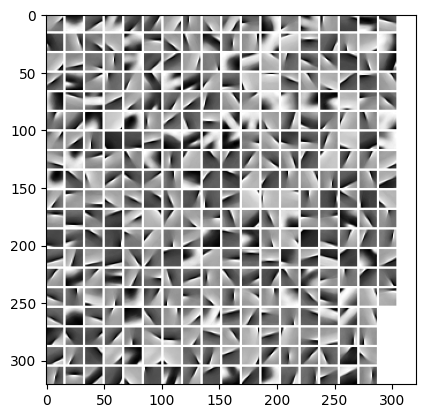

In [24]:
img_dict = get_dictionary_img(D)
plt.imshow(img_dict, cmap='gray')
plt.show()

## Confidence region estimation / density estimation

In [25]:
# PREPROCESSING: exclude black patches
v = np.median(V, axis=0)
V = V[:,v > 0.06]

In [26]:
# PREPROCESSING: remove the mean from each patch
for i in range(V.shape[1]):
  V[:,i] = V[:,i] - np.mean(V[:,i])

In [27]:
# sparse coding of each patch in V
X = np.zeros((natom, V.shape[1]))
for i in range(V.shape[1]):
  X[:, i] = OMP(V[:,i], D, L, 0)

In [28]:
# computing the anomaly indicators (l1 norm, reconstruction error) for each
# patch in V

V_tilde = np.zeros((2, V.shape[1]))     # each column contains the values of the anomaly_scores for a patch

for i in range(V.shape[1]):
  l1_norm = norm(X[:,i], ord=1)
  reconstruction_error = norm(V[:,i] - (D@X[:,i]), ord=2)
  V_tilde[:,i] = np.array([reconstruction_error, l1_norm])

# DISTIBUTION FITTING: Model normal estimation of mean and covariance

mu = np.mean(V_tilde, axis=1)
Sigma = np.cov(V_tilde)

## Threshold esimation

In [29]:
# estimation of the threshold that gives the desired false positive rate
# using the patches in V

FPR_target = 0.1

A = np.zeros((2, V.shape[1]))     # each column contains the feature vector for a patch

for i in range(V.shape[1]):
  l1_norm = norm(X[:,i], ord=1)
  reconstruction_error = norm(V[:,i] - (D@X[:,i]), ord=2)
  A[:,i] = np.array([reconstruction_error, l1_norm])

# compute the mahalanobis distance for each indicator vector in A
mahal_dist = np.zeros(V.shape[1])
for i in range(A.shape[1]):
    # this function puts in A the mahalanobis distance between mu and sigma^-1
     mahal_dist[i] = distance.mahalanobis(A[:,i], mu, np.linalg.inv(Sigma))

# set the threshold
threshold = np.quantile(mahal_dist,1-FPR_target)


## Test phase

In [30]:
# load the test image
img_test = imread(f'{rootfolder}/data/img_anom.png') / 255

# extract non-overlapping patches and store them in a matrix S
S = []
for i in range(0, img_test.shape[0], p):
    for j in range(0, img_test.shape[1], p):
      S.append(img_test[i:i+p,j:j+p].flatten())
S = np.array(S).T

# find the black patches, that are normal
v = np.median(S, axis=0)
index_black = np.where(v <= 0.06)[0]      # indexes of the column patch where the patch is black

# remove the mean value for each patch
for i in range(S.shape[1]):
  S[:,i] = S[:,i] - np.mean(S[:,i])

In [31]:
# sparse coding
X = np.zeros((natom, S.shape[1]))
for i in range(S.shape[1]):
  X[:, i] = OMP(S[:,i],D,L,0)

In [32]:
# computing the anomaly indicator

A_test = np.zeros((2, S.shape[1]))     #each column contains the feature vector for a patch

for i in range(S.shape[1]):
  l1_norm = norm(X[:,i], ord=1)
  reconstruction_error = norm(S[:,i] - (D@X[:,i]), ord=2)
  A_test[:,i] = np.array([reconstruction_error, l1_norm])


In [33]:
# compute the anomaly score for each test patch

anom_score = np.zeros(S.shape[1])
for i in range(S.shape[1]):
    anom_score[i] = distance.mahalanobis(A_test[:,i], mu, np.linalg.inv(Sigma))

# find the feature vector that fall outside the confidence region
anom_idx = np.where(anom_score > threshold)[0]

In [34]:
# remove the black_idx from the anon_idx
anom_idx = np.array(list(set(anom_idx) - set(index_black)))

In [35]:
# build the detection mask, that has the same size of the test image
# each pixel in the mask has value 1 if the corresponding patch has been
# detected as anomalous, otherwise it has value 0
mask = np.zeros_like(img_test)

k = 0
for i in range(0, img_test.shape[0]-p+1, p):
    for j in range(0, img_test.shape[1]-p+1, p):
        if k in anom_idx:
            mask[i:i+p,j:j+p] = 1
        k += 1

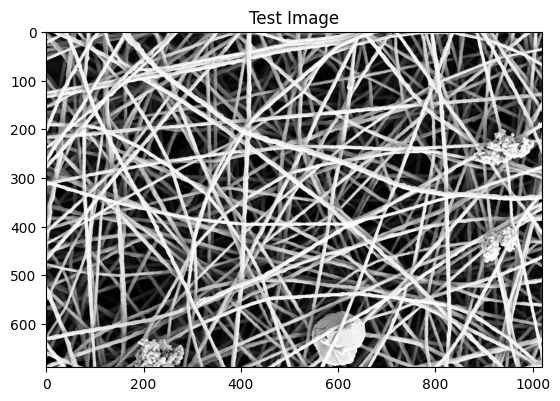

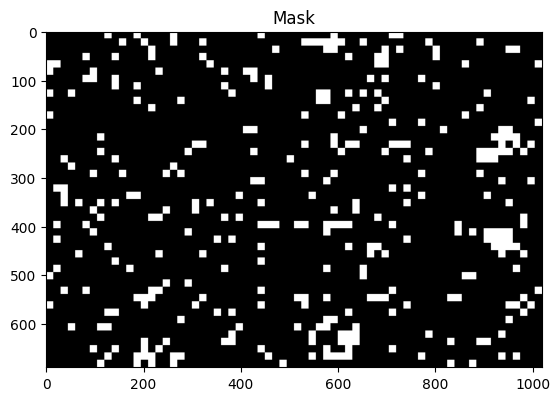

In [36]:
## show the results
plt.figure(3), plt.imshow(img_test, cmap='gray'), plt.title('Test Image')
plt.figure(4), plt.imshow(mask, cmap='gray'), plt.title('Mask')
plt.show()

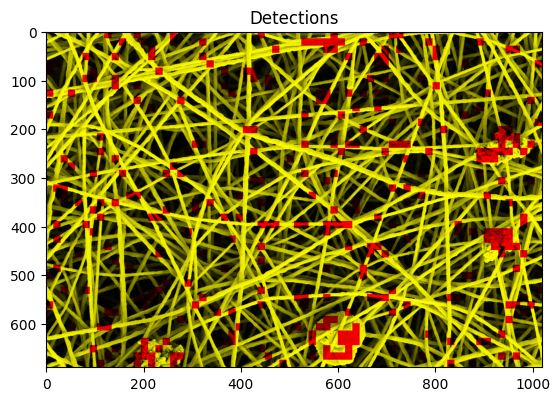

In [37]:
# combine the mask and the test image
img_color = np.zeros([img_test.shape[0], img_test.shape[1], 3])
img_temp = img_test.copy()
img_temp[mask > 0] = 1
img_color[:,:,0] = img_temp
img_temp = img_test.copy()
img_temp[mask > 0] = 0
img_color[:,:,1] = img_temp
img_temp = img_test.copy()
img_temp[mask > 2] = 0
img_color[:,:,0] = img_temp

plt.figure(5), plt.imshow(img_color), plt.title('Detections')
plt.show()

# Overlapping patches

In [42]:
# load the test image
img_test = imread(f'{rootfolder}/data/img_anom.png') / 255
imsz = img_test.shape

# initialize the scores image
scores = np.zeros_like(img_test)
# initialize the weight matrix
weights = np.zeros_like(img_test)

In [43]:
# MAIN LOOP
STEP = 5
S = []
for i in range(0, imsz[0] - p + 1, STEP):
    print(f'row {i} in a total of {imsz[0] - p + 1}')

    for j in range(0, imsz[1] - p + 1, STEP):
      # extrach the patch with the top left corner at pixel (ii, jj)
      s = img_test[i:i+p,j:j+p].flatten()
      S.append(s)

      # remove the mean value for the patch
      s -= s.mean()
      # perform the sparse coding of the patch s to compute the coefficients vector x
      x = OMP(s, D, L, 0)

      # computing the anomaly indicators (l1 norm, reconstruction error)
      l1_norm = norm(x, ord=1)
      reconstruction_error = norm(s - (np.dot(D,x)), ord=2)
      A = np.array([reconstruction_error, l1_norm])
      # compute the anomaly score
      anom_score = distance.mahalanobis(A, mu, np.linalg.inv(Sigma))

      #w = 1
      w = 1/max(1, np.count_nonzero(x))

      # put the denoised patch into the estimated image using uniform weights
      scores[i:i+p, j:j+p] += np.full((p, p), anom_score) * w

      # store the weight of the current patch in the weight matrix
      weights[i:i+p, j:j+p] += np.full((p, p), w)

scores = scores / weights

row 0 in a total of 676
row 5 in a total of 676
row 10 in a total of 676
row 15 in a total of 676
row 20 in a total of 676
row 25 in a total of 676
row 30 in a total of 676
row 35 in a total of 676
row 40 in a total of 676
row 45 in a total of 676
row 50 in a total of 676
row 55 in a total of 676
row 60 in a total of 676
row 65 in a total of 676
row 70 in a total of 676
row 75 in a total of 676
row 80 in a total of 676
row 85 in a total of 676
row 90 in a total of 676
row 95 in a total of 676
row 100 in a total of 676
row 105 in a total of 676
row 110 in a total of 676
row 115 in a total of 676
row 120 in a total of 676
row 125 in a total of 676
row 130 in a total of 676
row 135 in a total of 676
row 140 in a total of 676
row 145 in a total of 676
row 150 in a total of 676
row 155 in a total of 676
row 160 in a total of 676
row 165 in a total of 676
row 170 in a total of 676
row 175 in a total of 676
row 180 in a total of 676
row 185 in a total of 676
row 190 in a total of 676
row 195 

In [44]:
# find the black patches, that are normal
S = np.array(S).T
v = np.median(S, axis=0)
index_black = np.where(v <= 0.06)[0]

In [45]:
# build the detection mask, that has the same size of the test image
# each pixel in the mask has value 1 if the corresponding patch has been
# detected as anomalous, otherwise it has value 0
mask = np.zeros_like(img_test)

for i in range(img_test.shape[0]):
    for j in range(img_test.shape[1]):
      if scores[i,j] > threshold:
        mask[i,j] = 1

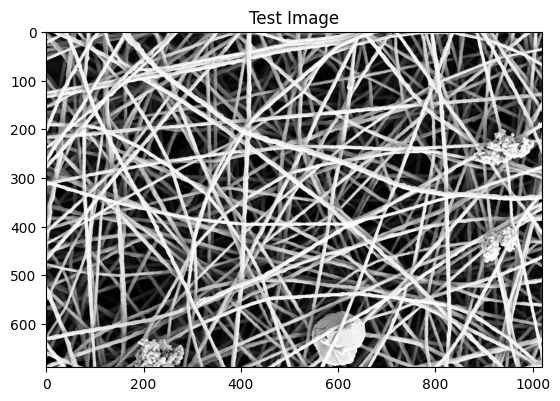

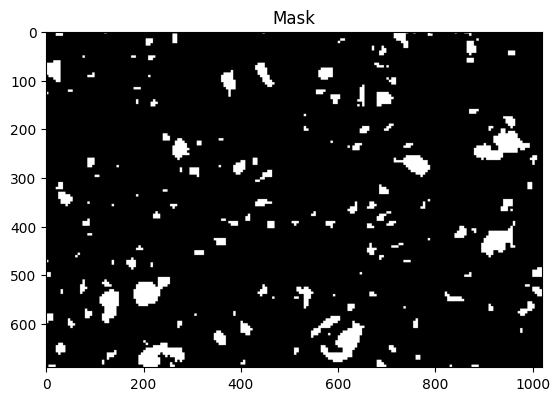

In [46]:
## show the results
plt.figure(3), plt.imshow(img_test, cmap='gray'), plt.title('Test Image')
plt.figure(4), plt.imshow(mask, cmap='gray'), plt.title('Mask')
plt.show()

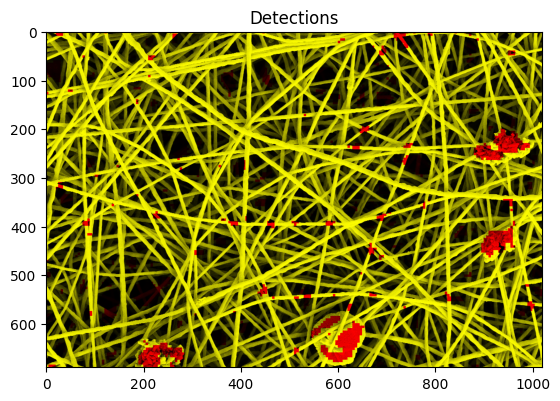

In [47]:
# combine the mask and the test image
img_color = np.zeros([img_test.shape[0], img_test.shape[1], 3])
img_temp = img_test.copy()
img_temp[mask > 0] = 1
img_color[:,:,0] = img_temp
img_temp = img_test.copy()
img_temp[mask > 0] = 0
img_color[:,:,1] = img_temp
img_temp = img_test.copy()
img_temp[mask > 2] = 0
img_color[:,:,0] = img_temp

plt.figure(5), plt.imshow(img_color), plt.title('Detections')
plt.show()